In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import re
import warnings
warnings.filterwarnings("ignore")
import logging
import os
import optuna
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error

In [2]:
df = pd.read_csv('final_data.csv')
df.salary_gross.fillna(False, inplace=True)
df.shape

(709524, 43)

In [3]:
def culc_metrics(y_test, y_pred):
    test_mse = mean_squared_error(y_test, y_pred)
    rmse = test_mse**0.5
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
        return smape

    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

    medae = median_absolute_error(y_test, y_pred)

    print(f'Корень из среднеквадратичной ошибки (RMSE): {rmse}')
    print(f"R² Score: {r2}")
    print(f"Средняя абсолютная ошибка (MAE): {mae}")
    print(f"Средняя абсолютная процентная ошибка (SMAPE): {smape:.2f}%")
    print(f"Медианная абсолютная ошибка (MedAE): {medae}")

### Mean Baseline model

In [4]:
mean_salary = df['salary'].mean()

predictions = np.full(df.shape[0], mean_salary)
true_values = df['salary'].values

culc_metrics(true_values, predictions)

Корень из среднеквадратичной ошибки (RMSE): 99590.3098849821
R² Score: 0.0
Средняя абсолютная ошибка (MAE): 42519.63234325419
Средняя абсолютная процентная ошибка (SMAPE): 46.64%
Медианная абсолютная ошибка (MedAE): 34089.93807447741


### Подготовка данных к обучению

In [5]:
cat_columns = ['premium', 'has_test', 'response_letter_required', 'area_name', 'salary_currency', 'salary_gross', 'type_name', 'address_city', 'address_metro_station_name', 'address_metro_line_name', 'address_metro_stations_0_line_name', 'archived', 'employer_name', 'employer_accredited_it_employer', 'employer_trusted', 'schedule_name', 'accept_temporary', 'professional_roles_0_name', 'accept_incomplete_resumes', 'experience_name', 'employment_name', 'address_metro_stations_3_station_name', 'address_metro_stations_3_line_name', 'working_time_intervals_0_name', 'working_time_modes_0_name', 'working_days_0_name', 'branding_type', 'branding_tariff', 'department_name', 'insider_interview_id', 'brand_snippet_logo', 'brand_snippet_picture', 'brand_snippet_background_color', 'brand_snippet_background_gradient_angle', 'brand_snippet_background_gradient_color_list_0_position', 'brand_snippet_background_gradient_color_list_1_position', 'category']
text_columns = ['name', 'snippet_requirement', 'snippet_responsibility']
num_columns = ['name_length', 'length']

In [6]:
scaler = StandardScaler()
num_df = pd.DataFrame(scaler.fit_transform(df[num_columns]), columns=num_columns)

In [7]:
label_columns = []
ohe_columns = []

for column in cat_columns:
    if df[column].nunique() > 10:
        label_columns.append(column)
    else:
        ohe_columns.append(column)

to_bool = list(df[cat_columns].select_dtypes(include=['bool']).columns)
df[['salary_gross', 'employer_accredited_it_employer']] = df[['salary_gross', 'employer_accredited_it_employer']].astype(bool).astype(int)
df[to_bool] = df[to_bool].astype(int)

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_encoded = ohe.fit_transform(df[ohe_columns])
ohe_feature_names = ohe.get_feature_names_out(ohe_columns).tolist()
encoded_ohe_data = pd.DataFrame(ohe_encoded, columns=ohe_feature_names)

label_encoder = LabelEncoder()
for col in label_columns:
    df[col] = label_encoder.fit_transform(df[col])
df[label_columns]

,area_name,address_city,address_metro_station_name,address_metro_line_name,address_metro_stations_0_line_name,employer_name,professional_roles_0_name,address_metro_stations_3_station_name,address_metro_stations_3_line_name,department_name,category
0,3284,4395,167,14,14,61563,84,0,0,139,7
1,3284,4395,34,19,19,95441,46,0,0,139,10
2,3284,4395,283,5,5,91973,46,0,0,139,12
3,1987,4395,99,2,2,46854,46,66,34,139,7
4,3466,4395,1,7,7,128549,55,0,0,139,3
...,...,...,...,...,...,...,...,...,...,...,...
709519,4618,6209,392,13,13,113906,115,0,0,438,9
709520,4618,6209,337,10,10,76081,28,0,0,139,2
709521,3284,4395,392,13,13,17924,115,0,0,139,9
709522,2514,3390,249,25,25,62999,84,0,0,139,7


In [8]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df], axis=1)
y = df['salary']

In [9]:
X_train, X_test_val, y_train, y_test_val, = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=12345)

print(f'Размеры выборок: Обучающая {X_train.shape}, Валидационная {X_test.shape}, Тестовая {X_val.shape}')

Размеры выборок: Обучающая (425714, 70), Валидационная (141905, 70), Тестовая (141905, 70)


### DecisionTreeRegressor

In [ ]:
model_dtr = DecisionTreeRegressor(random_state=12345)

regressor = TransformedTargetRegressor(
    regressor=model_dtr,
    func=np.log,
    inverse_func=np.exp
)


param_grid = {
    'regressor__max_depth': [10, 11, 12, 13, 14, 15, 16],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')


y_pred = best_model.predict(X_test)
culc_metrics(y_test, y_pred)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   2.2s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   2.4s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   2.5s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   2.7s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2; total time=   2.6s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5; total time=   2.6s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=2; total time=   2.7s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5; total time=   2.8s
[CV] END re

### LinearRegression

In [ ]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kfold
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Лучший RMSE на VAL кросс-валидации: {best_score:.4f}")

Лучшие параметры: {'alpha': 10}
Лучший RMSE на VAL кросс-валидации: 11602114729.5144


In [ ]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_test)
culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 64151.253113509396
R² Score: 0.2133895932442882
Средняя абсолютная ошибка (MAE): 32800.139580397095
Средняя абсолютная процентная ошибка (SMAPE): 36.36%
Медианная абсолютная ошибка (MedAE): 23599.38339362858


### RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators = 100, random_state=123)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 44484.30448880008
R² Score: 0.6217638720661233
Средняя абсолютная ошибка (MAE): 21484.423670028984
Средняя абсолютная процентная ошибка (SMAPE): 24.32%
Медианная абсолютная ошибка (MedAE): 12514.5


### CatBoost

In [ ]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df, df[text_columns]], axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

text_features_indices = [X.columns.get_loc(col) for col in text_columns]

In [ ]:
model = CatBoostRegressor(iterations=1500, learning_rate=0.0001, depth=6, verbose=0)
model.fit(X_train, y_train, text_features=text_features_indices)
y_pred = model.predict(X_test)

culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 72738.67567411887
R² Score: 0.069107422050953
Средняя абсолютная ошибка (MAE): 41696.838558920696
Средняя абсолютная процентная ошибка (SMAPE): 45.99%
Медианная абсолютная ошибка (MedAE): 34411.85295931041


Модель с текстовыми колонками работает очень долго
Стоит попробовать без них

In [ ]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df], axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

In [ ]:
model = CatBoostRegressor(iterations=1500, learning_rate=0.0001, depth=6, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 73759.42644008527
R² Score: 0.04279744307284694
Средняя абсолютная ошибка (MAE): 41187.002324358386
Средняя абсолютная процентная ошибка (SMAPE): 45.45%
Медианная абсолютная ошибка (MedAE): 33597.586754171665


Модель отработала за 16 секунд, rmse остался на том же уровне, но r2 сильно упал
Стоит попробовать кросс-валидацию и оптимизацию гиперпараметров

In [ ]:
model = CatBoostRegressor(iterations=1500, learning_rate=0.0001, depth=6, verbose=0)

param_grid = {
    'depth': [5, 6, 7, 8],
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
    'iterations': [1000, 1250, 1500, 1750, 2000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

culc_metrics(y_test, y_pred)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Корень из среднеквадратичной ошибки (RMSE): 53996.9639177637
R² Score: 0.48701168692199803
Средняя абсолютная ошибка (MAE): 29299.93847814121
Средняя абсолютная процентная ошибка (SMAPE): 32.66%
Медианная абсолютная ошибка (MedAE): 20747.6798167968
Best parameters found:  {'depth': 6, 'iterations': 1250, 'learning_rate': 0.01}


In [ ]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df, df[text_columns]], axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

text_features_indices = [X.columns.get_loc(col) for col in text_columns]

In [ ]:
model = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=6, verbose=0)
model.fit(X_train, y_train, text_features=text_features_indices)
y_pred = model.predict(X_test)

culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 54271.6901434194
R² Score: 0.48177843495127703
Средняя абсолютная ошибка (MAE): 29581.659199920625
Средняя абсолютная процентная ошибка (SMAPE): 33.25%
Медианная абсолютная ошибка (MedAE): 21173.341701797523


### AdaBoost

#### Feature Engineering

In [11]:
data = df.copy()

# Частота категорий
frequency_encoding = data['professional_roles_0_name'].value_counts(normalize=True).to_dict()
data['professional_roles_0_name_frequency'] = data['professional_roles_0_name'].map(frequency_encoding)

# Биннинг
data['name_length_binned'] = pd.cut(data['name_length'], bins=3, labels=['short', 'medium', 'long'])

# Логарифмирование
data['name_length_log'] = np.log1p(data['name_length'])

data.shape

(709524, 46)

In [12]:
cat_columns = ['name_length_binned', 'premium', 'has_test', 'response_letter_required', 'area_name', 'salary_currency', 'salary_gross', 'type_name', 'address_city', 'address_metro_station_name', 'address_metro_line_name', 'address_metro_stations_0_line_name', 'archived', 'employer_name', 'employer_accredited_it_employer', 'employer_trusted', 'schedule_name', 'accept_temporary', 'professional_roles_0_name', 'accept_incomplete_resumes', 'experience_name', 'employment_name', 'address_metro_stations_3_station_name', 'address_metro_stations_3_line_name', 'working_time_intervals_0_name', 'working_time_modes_0_name', 'working_days_0_name', 'branding_type', 'branding_tariff', 'department_name', 'insider_interview_id', 'brand_snippet_logo', 'brand_snippet_picture', 'brand_snippet_background_color', 'brand_snippet_background_gradient_angle', 'brand_snippet_background_gradient_color_list_0_position', 'brand_snippet_background_gradient_color_list_1_position', 'category']
text_columns = ['name', 'snippet_requirement', 'snippet_responsibility']
num_columns = ['name_length', 'length', 'name_length_log', 'professional_roles_0_name_frequency']

scaler = StandardScaler()
num_data = pd.DataFrame(scaler.fit_transform(data[num_columns]), columns=num_columns)

label_columns = []
ohe_columns = []

for column in cat_columns:
    if data[column].nunique() > 10:
        label_columns.append(column)
    else:
        ohe_columns.append(column)

to_bool = list(data[cat_columns].select_dtypes(include=['bool']).columns)
data[['salary_gross', 'employer_accredited_it_employer']] = data[['salary_gross', 'employer_accredited_it_employer']].astype(bool).astype(int)
data[to_bool] = data[to_bool].astype(int)

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_encoded = ohe.fit_transform(data[ohe_columns])
ohe_feature_names = ohe.get_feature_names_out(ohe_columns).tolist()
encoded_ohe_data = pd.DataFrame(ohe_encoded, columns=ohe_feature_names)

label_encoder = LabelEncoder()
for col in label_columns:
    data[col] = label_encoder.fit_transform(data[col])
data[label_columns]

X = pd.concat([data[label_columns], encoded_ohe_data, num_data], axis=1)
y = data['salary']

X_train, X_test_val, y_train, y_test_val, = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=12345)

print(f'Размеры выборок: Обучающая {X_train.shape}, Валидационная {X_test.shape}, Тестовая {X_val.shape}')

Размеры выборок: Обучающая (425714, 74), Валидационная (141905, 74), Тестовая (141905, 74)


#### Model dev

In [13]:
LOG_FILEPATH = '../logs'
logging.basicConfig(filename=os.path.join(LOG_FILEPATH, 'AdaBoost.log'), level=logging.INFO, format='%(asctime)s: %(message)s')
logger = logging.getLogger()

In [14]:
def objective(trial):
    logger.info(f"Starting trial {trial.number}")
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.03)
    base_estimator_max_depth = trial.suggest_int('base_estimator_max_depth', 1, 9)
    logger.info(f"Trial params: n_estimators: {n_estimators}, learning_rate: {learning_rate}, base_estimator_max_depth: {base_estimator_max_depth}")

    base_model = DecisionTreeRegressor(max_depth=base_estimator_max_depth)
    
    model = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=12345
    )

    scores = []
    for i, (train_idx, val_idx) in enumerate(KFold(n_splits=3, shuffle=True, random_state=12345).split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        y_pred = np.clip(y_pred, 0, None)
        rmsle = np.sqrt(mean_squared_log_error(y_val_fold, y_pred))
        logger.info(f"RMSLE score of {i} itter: {rmsle}") 
        scores.append(rmsle)
    logger.info(f"Finished trial {trial.number}")    

    return np.mean(scores)

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, n_jobs=1)

[I 2025-03-12 14:56:36,256] A new study created in memory with name: no-name-58224cca-b5f5-4a9b-b415-f72f474da19f
[I 2025-03-12 15:11:42,777] Trial 0 finished with value: 0.630083311895116 and parameters: {'n_estimators': 154, 'learning_rate': 0.012350841802163495, 'base_estimator_max_depth': 3}. Best is trial 0 with value: 0.630083311895116.
[I 2025-03-12 15:35:14,766] Trial 1 finished with value: 0.6234679452817232 and parameters: {'n_estimators': 197, 'learning_rate': 0.01278951047478168, 'base_estimator_max_depth': 4}. Best is trial 1 with value: 0.6234679452817232.
[I 2025-03-12 15:45:03,277] Trial 2 finished with value: 0.620346297725262 and parameters: {'n_estimators': 129, 'learning_rate': 0.0003297832108630159, 'base_estimator_max_depth': 2}. Best is trial 2 with value: 0.620346297725262.
[I 2025-03-12 15:52:49,465] Trial 3 finished with value: 0.6283199164357134 and parameters: {'n_estimators': 79, 'learning_rate': 0.018112420252700573, 'base_estimator_max_depth': 3}. Best is

In [16]:
print(f'Best trial: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')

Best trial: 0.5334134530462502
Best parameters: {'n_estimators': 123, 'learning_rate': 0.00202759581518893, 'base_estimator_max_depth': 8}


Best parameters: {'n_estimators': 123, 'learning_rate': 0.00202759581518893, 'base_estimator_max_depth': 8}

In [19]:
best_params = study.best_trial.params
best_model_adaboost = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params['base_estimator_max_depth']),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
).fit(X_train, y_train)

In [20]:
y_pred = best_model_adaboost.predict(X_test)

culc_metrics(y_test, y_pred)

Корень из среднеквадратичной ошибки (RMSE): 52624.3229777295
R² Score: 0.4706749556317317
Средняя абсолютная ошибка (MAE): 31336.274066145175
Средняя абсолютная процентная ошибка (SMAPE): 35.46%
Медианная абсолютная ошибка (MedAE): 22492.85249535524


### XGBoost

In [ ]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df], axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

model = XGBRegressor(objective='reg:squarederror', n_estimators=1250, learning_rate=0.01, max_depth=6, verbosity=0)
param_grid = {
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [1000, 1500, 2000]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

culc_metrics(y_test, y_pred)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Корень из среднеквадратичной ошибки (RMSE): 55360.58799637801
R² Score: 0.4607748045033424
Средняя абсолютная ошибка (MAE): 30357.43626278008
Средняя абсолютная процентная ошибка (SMAPE): 34.26%
Медианная абсолютная ошибка (MedAE): 21872.0234375
Best parameters found:  {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 2000}


### LightGBM

In [ ]:
X = pd.concat([df[label_columns], encoded_ohe_data, num_df], axis=1)
y = df['salary']

X.columns = [re.sub(r"[ \.\-#:]+", "_", col) for col in X.columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)

In [ ]:
model = lgb.LGBMRegressor(objective='regression', n_estimators=1250, learning_rate=0.01, max_depth=6, verbosity=-1)

param_grid = {
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [1000, 1500, 2000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

culc_metrics(y_test, y_pred)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Корень из среднеквадратичной ошибки (RMSE): 53473.19215970539
R² Score: 0.496915415856513
Средняя абсолютная ошибка (MAE): 26745.592593777295
Средняя абсолютная процентная ошибка (SMAPE): 29.52%
Медианная абсолютная ошибка (MedAE): 17557.40014850231
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500}


### Снижение размерности

In [ ]:
print(f"Число признаков в датафрейме: {X.shape[1] - 1}")
print("Список признаков:", X.columns.tolist())

#### Шаг 1

In [ ]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

X_reduced = X.drop(columns=to_drop)
print(f"Удалено {len(to_drop)} коррелированных признаков")

In [ ]:
print(f"Число признаков в датафрейме: {X_reduced.shape[1] - 1}")
print("Список признаков:", X_reduced.columns.tolist())

In [ ]:
X_reduced_train, X_reduced_test_val, y_reduced_train, y_reduced_test_val, = train_test_split(X_reduced, y, test_size=0.4, random_state=12345)
X_reduced_test, X_reduced_val, y_reduced_test, y_reduced_val = train_test_split(X_reduced_test_val, y_reduced_test_val, test_size=0.5, random_state=12345)

print(f'Размеры выборок: Обучающая {X_reduced_train.shape}, Валидационная {X_reduced_test.shape}, Тестовая {X_reduced_val.shape}')

#### Шаг 2

In [ ]:
counts_features = [20, 25, 30, 35]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_reduced_train, y_reduced_train)

feature_importances = pd.Series(model.feature_importances_, index=X_reduced_train.columns)

In [ ]:
features_obj = {}

for N in counts_features:
  important_features = feature_importances.nlargest(N).index

  print(f"Оставлено {len(important_features)} важных признаков")
  print(important_features)

  start_time_RFR_reduced = time.time()
  model = RandomForestRegressor(n_estimators = 100, random_state=123)

  model.fit(X_reduced_train[important_features], y_reduced_train)
  end_time_RFR_reduced = time.time()

  training_time_RFR_reduced = end_time_RFR_reduced - start_time_RFR_reduced

  print(f"Результаты модели ======================================================")
  print(f"Время обучения модели для {N} показателей - {int(training_time_RFR_reduced // 60)} минут и {int(training_time_RFR_reduced % 60)} секунд")

  y_reduced_pred = model.predict(X_reduced_test[important_features])
  culc_metrics(y_reduced_test, y_reduced_pred)


#### Итог
Информация по обучению модели на всех параметрах:

*   Время - 12 минут 40 секунд
*   RMSE: 44093
*   R2 Scrore: 0.628

Информация по обучению модели на всех 20 параметрах:

*   Время - 8 минут и 17 секунд
*   RMSE: 52192
*   R2 Scrore: 0.479

Информация по обучению модели на всех 25 параметрах:

*   Время - 9 минут и 8 секунд
*   RMSE: 44846
*   R2 Scrore: 0.615

Информация по обучению модели на всех 30 параметрах:

*   Время - 10 минут и 8 секунд
*   RMSE: 44679
*   R2 Scrore: 0.618

Информация по обучению модели на всех 35 параметрах:

*   Время - 10 минут и 22 секунд
*   RMSE: 44679
*   R2 Scrore: 0.623

По итогу было принято взять 25 лучших параметров, так как при такой выборке, время обучения снизилось на 28% и при этом потеря в качестве минимальна

In [ ]:
important_features_result = feature_importances.nlargest(25).index
print(important_features)

X_reduced_train_result = X_reduced_train[important_features_result]
X_reduced_test_result = X_reduced_test[important_features_result]
X_reduced_val_result = X_reduced_val[important_features_result]

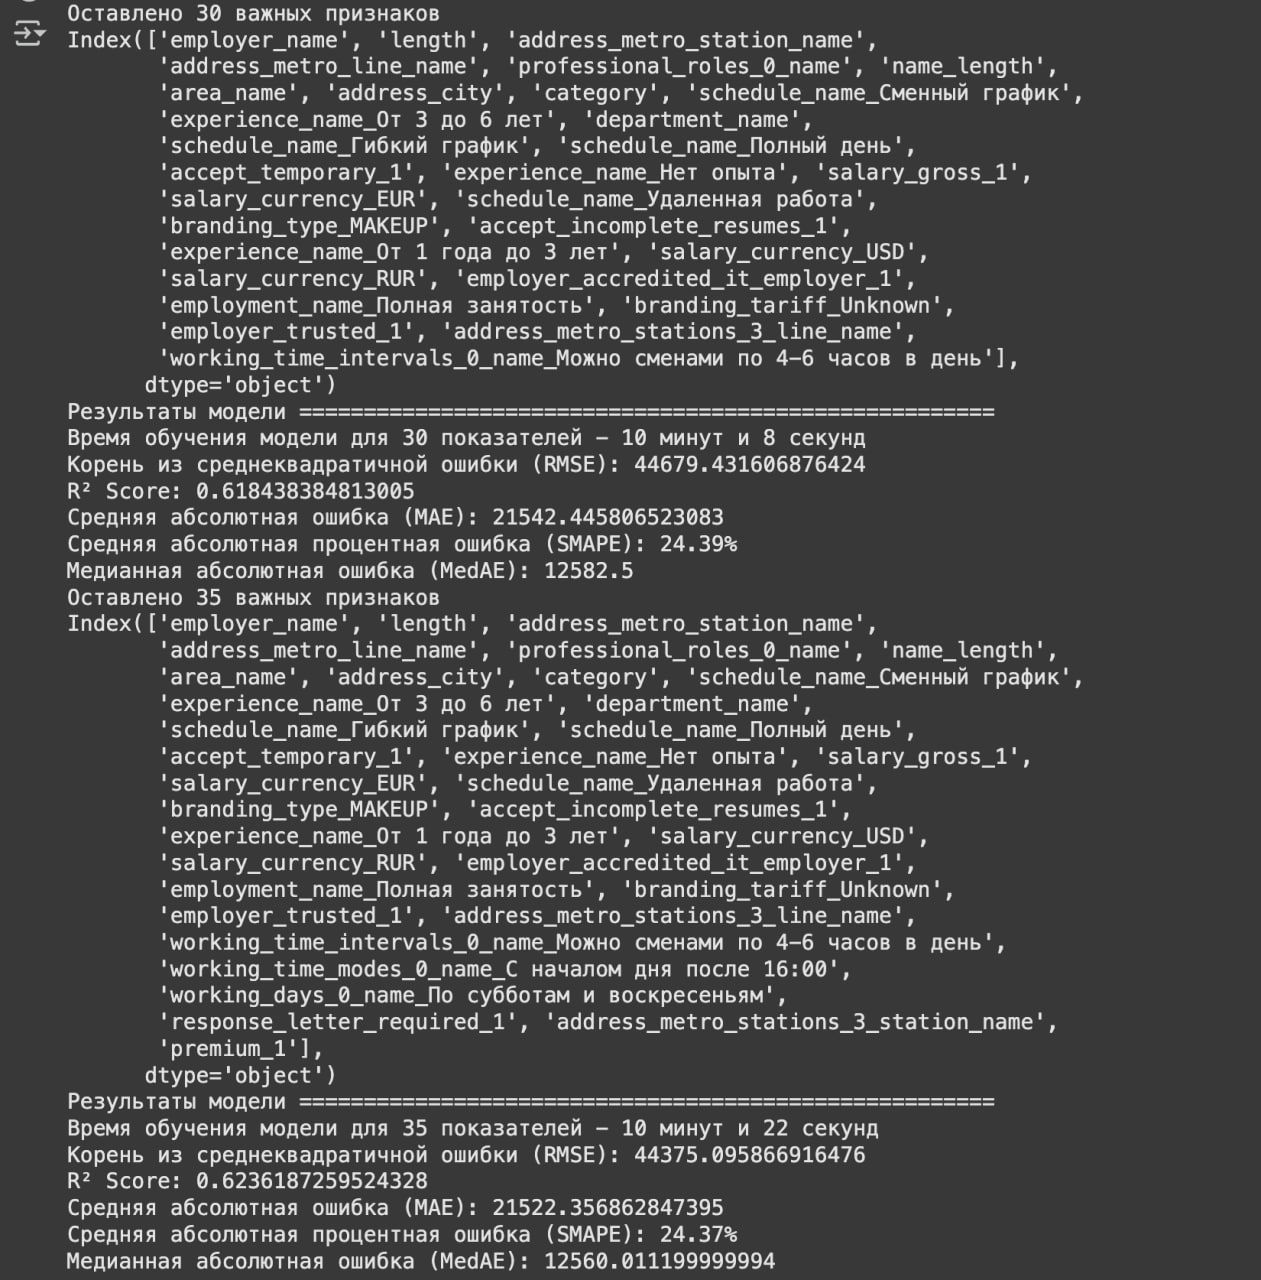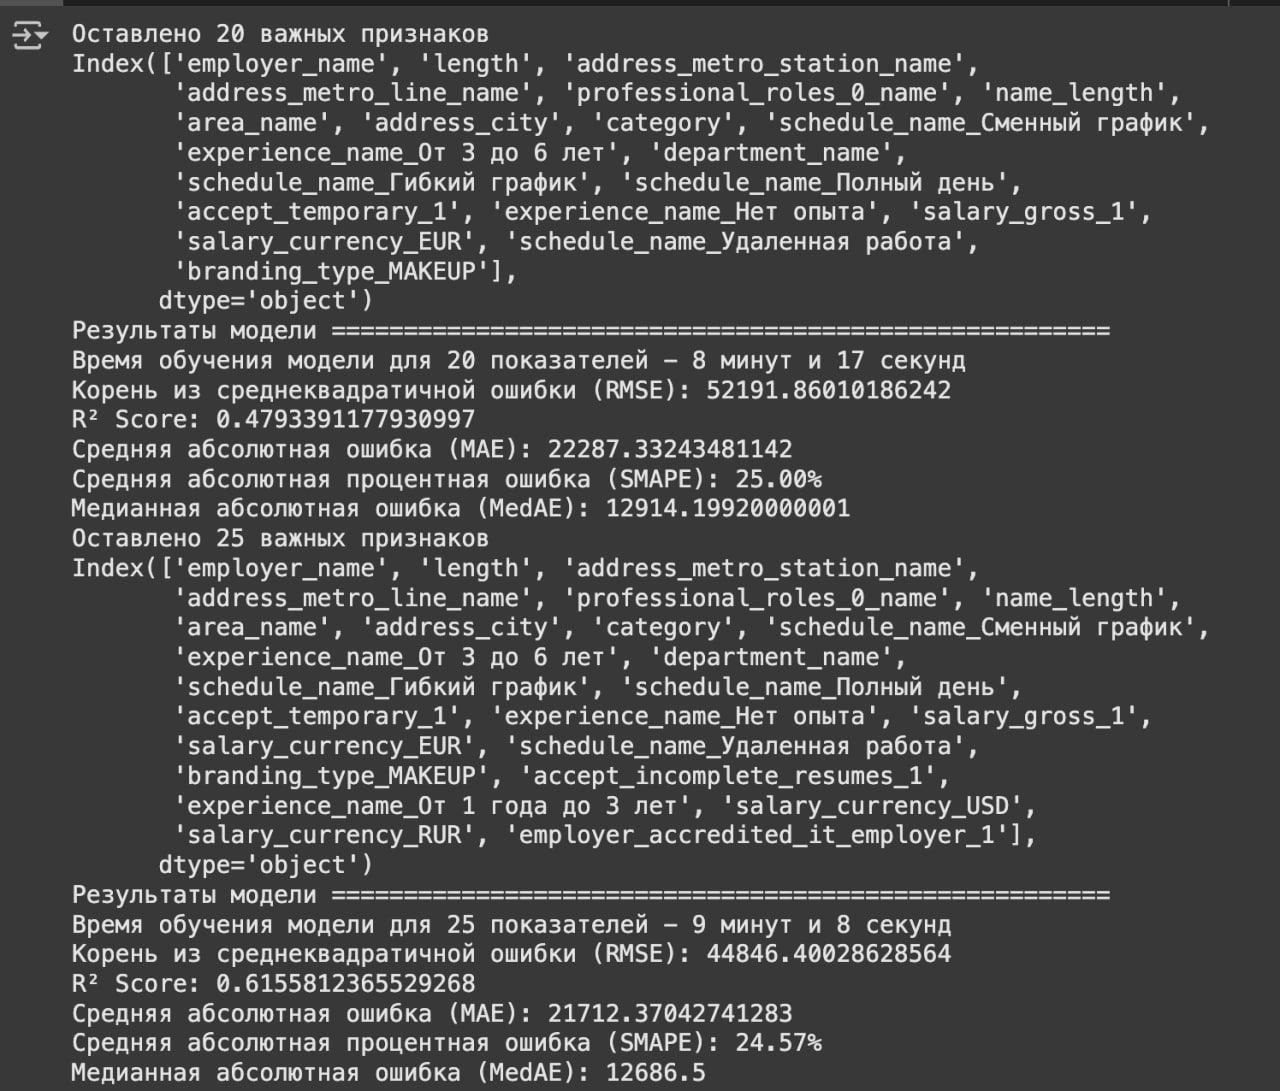